# [作業目標]
- 使用 Day 17 剛學到的方法, 對較完整的資料生成離散化特徵
- 觀察上述離散化特徵, 對於目標值的預測有沒有幫助

# [作業重點]
- 仿照 Day 17 的語法, 將年齡資料 ('DAYS_BIRTH' 除以 365) 離散化
- 繪製上述的 "離散化標籤" 與目標值 ('TARGET') 的長條圖

In [1]:
# 載入需要的套件
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
%matplotlib inline
plt.style.use('ggplot')

# 忽略警告訊息
import warnings
warnings.filterwarnings('ignore')

# 設定 data_path
dir_data = './data/'

### 之前做過的處理

In [2]:
# 讀取 csv 資料檔, 並觀察前幾筆資料 ( .head() )
f_app_train = os.path.join(dir_data, 'application_train.csv')
app_train = pd.read_csv(f_app_train)
app_train.shape

(307511, 122)

In [3]:
# 將只有兩種值的類別型欄位, 做 Label Encoder, 計算相關係數時讓這些欄位可以被包含在內
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder() # label encoding : 把每個類別 mapping 到某個整數，不會增加新欄位

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            # 就做 Label Encoder, 以加入相關係數檢查
            app_train[col] = le.fit_transform(app_train[col])            
print(app_train.shape)
app_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,0,M,0,1,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,0,F,0,0,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,1,M,1,1,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,0,F,0,1,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,0,M,0,1,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])

## 練習時間
參考 Day 17 範例程式，離散化你覺得有興趣的欄位，並嘗試找出有趣的訊息

In [5]:
app_train['YEARS_BIRTH'] = app_train['DAYS_BIRTH']/365
app_train['YEARS_BIRTH'].head(20)

0     25.920548
1     45.931507
2     52.180822
3     52.068493
4     54.608219
5     46.413699
6     37.747945
7     51.643836
8     55.065753
9     39.641096
10    27.936986
11    55.936986
12    36.819178
13    38.591781
14    39.953425
15    23.912329
16    35.427397
17    26.783562
18    48.542466
19    31.090411
Name: YEARS_BIRTH, dtype: float64

### 連續型特徵離散化
雖然由之前的分析發現 DAYS_BIRTH 與 TARGET 的相關係數只有 -0.07，  
但在往後的課程裡，為了實際解決問題，我們將需透過一些處理方法，改善相關係數。  
目前我們先以對資料的常識理解，去觀察這兩個欄位的交叉狀況。

In [6]:
app_train['YEARS_BIRTH'].describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: YEARS_BIRTH, dtype: float64

年齡最小是 20，最大是 69，那我們可以把年齡每 5 歲為一組後再來觀察其與預測目標的關係
***
## pd.cut
## 語法說明
### pandas.cut(x, bins, right=True, labels=None, retbins=False, precision=3, include_lowest=False)

##### 用途：返回 x中的每一個數據在bins 中對應的範圍
##### 參數：

- x ： 必須是一維資料

- bins： 不同面元（不同範圍）型別:整數，序列如陣列, 和IntervalIndex

- right： 最後一個bins是否包含最右邊的資料，預設為True

- precision：精確度，預設為保留到小數位數第3位

- retbins： 即return bins，是否返回每一個bins的範圍，預設為False
***************
## 等寬劃分
### 等寬劃分：按照相同寬度將資料分成幾等份。缺點是受到異常值的影響比較大。

In [11]:
# 將年齡相關資料, 另外存成一個 DataFrame 來處理
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# 將年齡資料離散化 / 分組
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


## np.linspace() 說明
### np.linspace(start, stop, num=50, endpoint=True, retstep=False, dtype=None)
##### 說明:在指定的間隔內返回均勻間隔的數字，返回num均匀分布的样本，在[start, stop]。

In [12]:
# 依照組別彙整年齡資料 "每一欄的平均值"
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


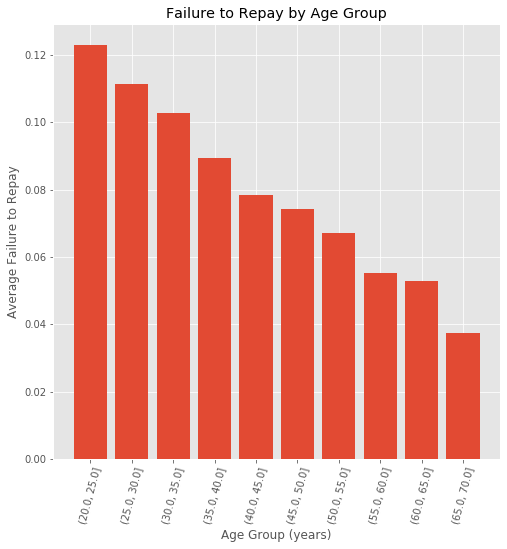

In [13]:
plt.figure(figsize = (8, 8))

# 繪製目標值平均與分組組別的長條圖
plt.bar(range(len(age_groups.index)), age_groups['TARGET'])
# 加上 X, y 座標說明, 以及圖表的標題
plt.xticks(range(len(age_groups.index)), age_groups.index, rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Average Failure to Repay')
plt.title('Failure to Repay by Age Group');

可以非常明顯地看出趨勢，越年輕的客戶族群的違約遲繳的可能越大！